# Max Sharpe Ratio Portfolio

In [1]:
import numpy as np
import pandas as pd

%load_ext autoreload
%autoreload 2
import kit as erk    

In [2]:
ind = erk.get_ind_returns()

# Expected Returns
er = erk.annualize_rets(ind["1996":"2000"])

# Covariance Matrix
cov = ind["1996":"2000"].cov()

We already know how to identify points on the curve if we are given a target rate of return. Instead of minimizing the volatility based on a target return, we want to find that one point on the curve that maximizes the Sharpe Ratio, given the a risk free rate. In other words, the tangent point of the Efficient Frontier and the **Capital Market Line [CML]**.

In [3]:
from scipy.optimize import minimize
def msr(riskfree_rate, er, cov):
    """
    Returns the weights that achieve the Maximun Sharp Ratio Porfolio [MSR]

    weights : x   Optimization target parameter
    """

    # Initial values
    n = er.shape[0]
    init_guess = np.repeat(1/n, n)

    # Frontier values
    bounds = ((0, 1),) * n 


    # Constraints   |   weights : x   target

    weights_sum_to_1 = {'type': 'eq', # Check when Constrain Function [fun] equals 0
                        
                        # The funtion is 0 only when Σ(w) == 1  , So, only when x is equal to 1
                        'fun': lambda weights: np.sum(weights) - 1 }
    

    # Objective Function
    def neg_sharpe(weights, riskfree_rate, er, cov):
        """
        Returns the negative of the sharpe ratio of the given portfolio
        """
        r = erk.portfolio_return(weights, er)
        vol = erk.portfolio_vol(weights, cov)
        return -(r - riskfree_rate)/vol


    # Optimization Function
    weights = minimize(neg_sharpe, 
                       init_guess, # Initial values
                       args= (riskfree_rate, er, cov),
                       method= 'SLSQP', # Quadratic Optimizer

                       options= {'disp': False},
                       constraints= (weights_sum_to_1),
                       bounds= bounds
                    )
    

    return weights.x 

Let's put it all together by adding the CML to the `plot_ef` code.

In [4]:
def plot_ef(n, er, cov, cml = False, riskfree_rate= 0):
    """
    Plots the multi-asset efficient frontier
    """
    def optimal_weights(n, er, cov):
        ''' Volatility Optimization implementation'''
        targets = np.linspace(er.min(), er.max(), n)
        weights = [erk.minimize_vol(t, er, cov) for t in targets]

        return weights

    weights = optimal_weights(n, er, cov)
    rets = [erk.portfolio_return(w, er) for w in weights]
    vols = [erk.portfolio_vol(w, cov) for w in weights]

    ef = pd.DataFrame( {"Returns": rets, "Volatility": vols} )

    ax = ef.plot.line(x="Volatility", y="Returns", style='.')

    if cml:
        ax.set_xlim(left = 0)

        # MSR
        w_msr = msr(riskfree_rate, er, cov)
        r_msr = erk.portfolio_return(w_msr, er)
        vol_msr = erk.portfolio_vol(w_msr, cov)

        # CML
        cml_x = [0, vol_msr]; cml_y = [riskfree_rate, r_msr]
        ax.plot(cml_x, cml_y, color='green', marker='o', linestyle='dashed', linewidth=2, markersize= 8)

    return ax

<Axes: xlabel='Volatility'>

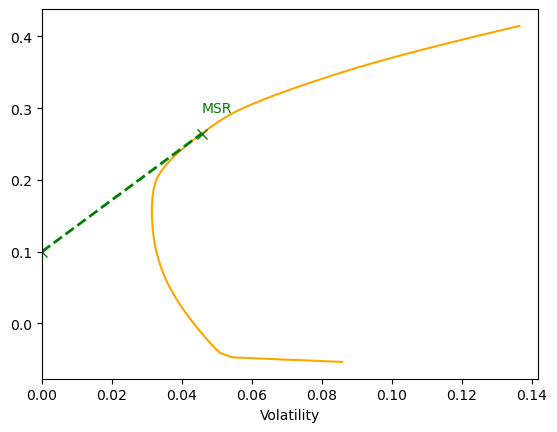

In [5]:
erk.plot_ef(n_points= 75, expected_returns= er, cov= cov, style= '-', show_cml= True, riskfree_rate= 0.1)